In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import psycopg2

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.declarative import declarative_base
# Allow us to declare column types
from sqlalchemy import Column, Integer, String, Float 
from sqlalchemy.sql.expression import bindparam
from sqlalchemy import Interval
from datetime import timedelta

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row1 = session.query(Measurement).first()
first_row1.__dict__
max_date_row1 = session.query(Measurement).first()
max_date_row1.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21c194086a0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1}

In [11]:
first_row2 = session.query(Station).first()
first_row2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21c19408ca0>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [12]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

maxDate=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
maxDate=maxDate[0]
print("Max Date: "+maxDate)

#year,month,day=maxDate.split('-')
#earlyDate=datetime.date(int(year), int(month), int(day))-timedelta(days=365)


# Perform a query to retrieve the date and precipitation scores
precips = session.query(Measurement).filter(Measurement.date >='2016-08-23').filter(Measurement.date <= '2017-08-23').all()
#precips = session.query(Measurement).filter(Measurement.date >= earlyDate).filter(Measurement.date <= maxDate).all()
precips_df=pd.DataFrame(columns = ["Date", "Precip"])

for precip in precips:
    precips_df=precips_df.append({'Date':precip.date,'Precip':precip.prcp}, ignore_index=True)

precips_df = pd.DataFrame(precips_df)

# Save the query results as a Pandas DataFrame and set the index to the date column
precips_df = precips_df.set_index('Date')
precips_df = precips_df.dropna() 
# Sort the dataframe by date
precips_df = precips_df.sort_index() 
precips_df.head()

Max Date: 2017-08-23


,Precip
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


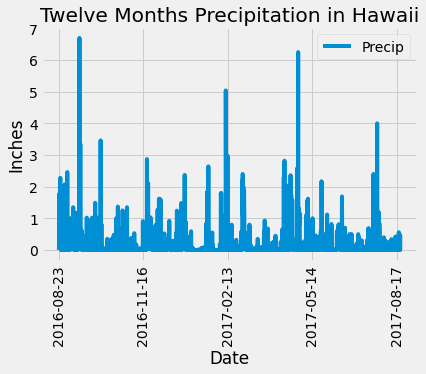

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
precips_df.plot(rot=90)
plt.title("Twelve Months Precipitation in Hawaii")
#plt.xlabel("Cities")
plt.ylabel("Inches")
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print("Mean Precipitation: "+str(precips_df['Precip'].mean()))
print("Median Precipitation: "+str(precips_df['Precip'].median()))
print("Mode of Precipitation: "+str(precips_df['Precip'].mode()))
quartiles = precips_df['Precip'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of precipitation is: {lowerq}")
print(f"The upper quartile of precipitation is: {upperq}")
print(f"The interquartile range of precipitation is: {iqr}")
print(f"The the median of precipitation is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outliers = precips_df.loc[(precips_df['Precip'] < lower_bound) | (precips_df['Precip'] > upper_bound)]
outliers

Mean Precipitation: 0.17727857496288899
Median Precipitation: 0.02
Mode of Precipitation: 0    0.0
dtype: float64
The lower quartile of precipitation is: 0.0
The upper quartile of precipitation is: 0.13
The interquartile range of precipitation is: 0.13
The the median of precipitation is: 0.02 
Values below -0.195 could be outliers.
Values above 0.325 could be outliers.


,Precip
Date,
2016-08-23,0.70
2016-08-23,1.79
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,2.15
...,...
2017-08-15,0.42
2017-08-16,0.42
2017-08-21,0.56


In [18]:
# Design a query to show how many stations are available in this dataset?
'''
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
'''

stations = session.query(Station).all()
stations_df=pd.DataFrame(columns = ["Station", "Name", "Latitude", "Longitude", "Elevation"])

for station in stations:
    stations_df=stations_df.append({'Station':station.station,'Name':station.name,'Latitude':station.latitude,'Longitude':station.longitude,'Elevation':station.elevation}, ignore_index=True)
    
print("Number of stations: "+str(len(stations_df)))

stations_df = pd.DataFrame(stations_df)
stations_df


Number of stations: 9


,Station,Name,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
'''
Station
---------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

Measurement
---------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
'''

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.date, Measurement.prcp, Measurement.tobs]
results = session.query(*sel).filter(Station.station == Measurement.station).all()


In [21]:
results_df=pd.DataFrame(columns = ["Station", "Name", "Latitude", "Longitude", "Elevation", "Date", "Precip", "Tobs"])

for result in results:
    station_station, station_name, station_lat, station_lon, station_elev, measure_date, measure_prcp, measure_tobs = result
    results_df=results_df.append({'Station':station_station,'Name':station_name,'Latitude':station_lat,'Longitude':station_lon,'Elevation':station_elev,'Date':measure_date,'Precip':measure_prcp, 'Tobs':measure_tobs}, ignore_index=True)

#results_df  = results_df .dropna() 
results_df

,Station,Name,Latitude,Longitude,Elevation,Date,Precip,Tobs
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-01,0.08,65.0
1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-02,0,63.0
2,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-03,0,74.0
3,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-04,0,76.0
4,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-06,None,73.0
...,...,...,...,...,...,...,...,...
19545,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,2017-08-19,0.09,71.0
19546,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,2017-08-20,None,78.0
19547,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,2017-08-21,0.56,76.0
19548,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,2017-08-22,0.5,76.0


In [34]:
#results_df.groupby(by='Station').agg('count')
station_count_df=pd.DataFrame(results_df["Name"].value_counts())
station_count_df.reset_index()

station_count_df.rename(columns = {'Name':'Count'}, inplace = True) 
station_count_df

,Count
"WAIHEE 837.5, HI US",2772
"WAIKIKI 717.2, HI US",2724
"KANEOHE 838.1, HI US",2709
"WAIMANALO EXPERIMENTAL FARM, HI US",2669
"MANOA LYON ARBO 785.2, HI US",2612
"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
"HONOLULU OBSERVATORY 702.2, HI US",1979
"PEARL CITY, HI US",1372
"UPPER WAHIAWA 874.3, HI US",511


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
